In [176]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
import numpy as np
import re
import os
sns.set_style("darkgrid")
plt.rcParams.update({'font.size': 25})

In [177]:
COLUMNS = ['period', 'wifi', 'Stack', 'Mbps']

In [178]:
runs = os.listdir('./formated_data')
experiments = {key: list(group) for key, group in itertools.groupby(runs, key=lambda exp_run: exp_run[:-6])}

In [179]:
print(experiments.keys())

dict_keys(['A1I1M1', 'A1I1M2', 'A1I1M3', 'A1I2M1', 'A1I2M2', 'A1I2M3', 'A2I1M1', 'A2I1M2', 'A2I1M3', 'A2I2M1', 'A2I2M2', 'A2I2M3', 'A3I1M1', 'A3I1M2', 'A3I1M3', 'A3I2M1', 'A3I2M2', 'A3I2M3'])


In [180]:
experiments_df = {key: pd.concat([pd.read_csv(f'./formated_data/{file_names}', usecols=COLUMNS) for file_names in experiments[key]]) for key in experiments}

In [181]:
keys_group_by_model = {key: list(group) for key, group in itertools.groupby(experiments.keys(), key=lambda exp_run: exp_run[:-2])}
print(keys_group_by_model)
keys_group_by_model = {key: list(group) for key, group in itertools.groupby(experiments.keys(), key=lambda exp_run: exp_run[:2])}
print(keys_group_by_model)

{'A1I1': ['A1I1M1', 'A1I1M2', 'A1I1M3'], 'A1I2': ['A1I2M1', 'A1I2M2', 'A1I2M3'], 'A2I1': ['A2I1M1', 'A2I1M2', 'A2I1M3'], 'A2I2': ['A2I2M1', 'A2I2M2', 'A2I2M3'], 'A3I1': ['A3I1M1', 'A3I1M2', 'A3I1M3'], 'A3I2': ['A3I2M1', 'A3I2M2', 'A3I2M3']}
{'A1': ['A1I1M1', 'A1I1M2', 'A1I1M3', 'A1I2M1', 'A1I2M2', 'A1I2M3'], 'A2': ['A2I1M1', 'A2I1M2', 'A2I1M3', 'A2I2M1', 'A2I2M2', 'A2I2M3'], 'A3': ['A3I1M1', 'A3I1M2', 'A3I1M3', 'A3I2M1', 'A3I2M2', 'A3I2M3']}


In [182]:
def plot_stats(experiments_df, metric):
    key_groups = {key: list(group) for key, group in itertools.groupby(experiments.keys(), key=lambda exp_run: exp_run[:2])}
    for key_group in key_groups:
        for key in key_groups:
            print(key)
            for df_key in key_groups[key]:
                experiments_df[df_key]['model'] = key
    for a1, a2, a3 in zip(*[[df_key for df_key in key_groups[key]] for key in key_groups]):
        df = pd.concat([experiments_df[a1], experiments_df[a2], experiments_df[a3]]) 
        df = df[df['period'] > 0]
        df = df[df['period'] <= 170]
        df = df[df['period'] % 10 == 0]
        fig, axis = plt.subplots(1, 1, figsize=(15, 10))
        sns.boxplot(x='period', y=metric, hue='model', data=df, palette="Set3", showfliers=False, ax=axis)
        axis.set_title(a1[2:])
        fig.savefig(f'./graphs/{a1[2:]}_{metric}.jpg')

A1
A2
A3
A1
A2
A3
A1
A2
A3


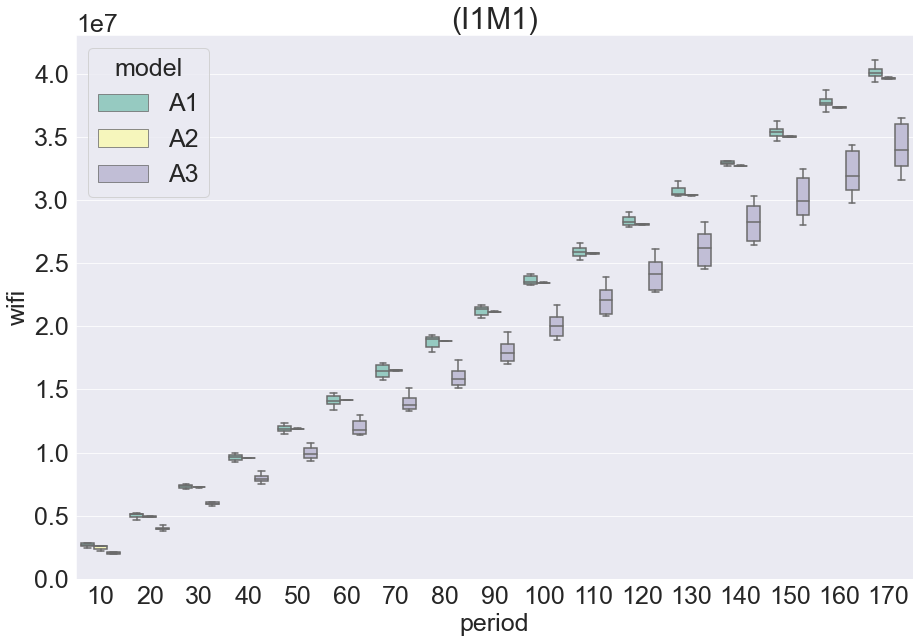

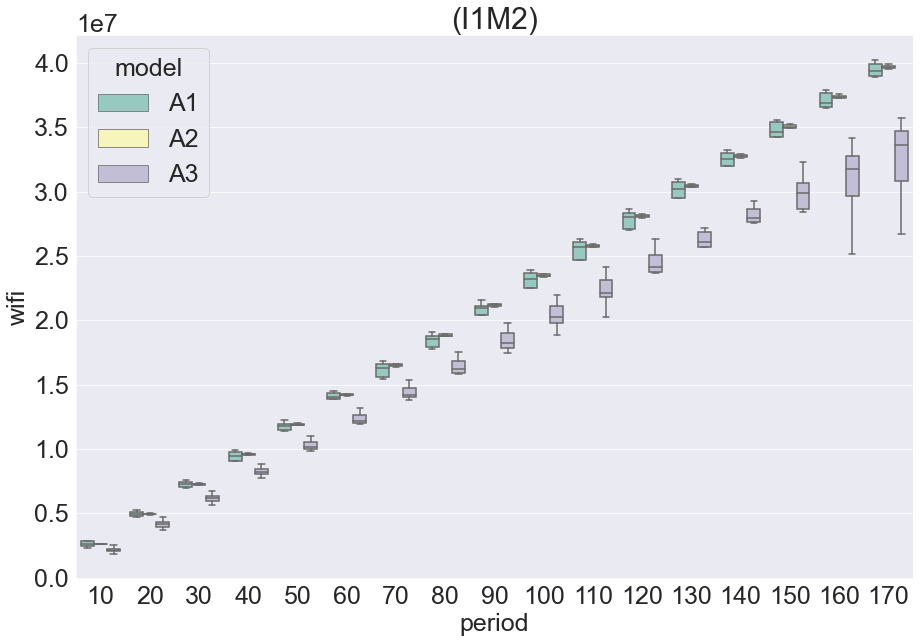

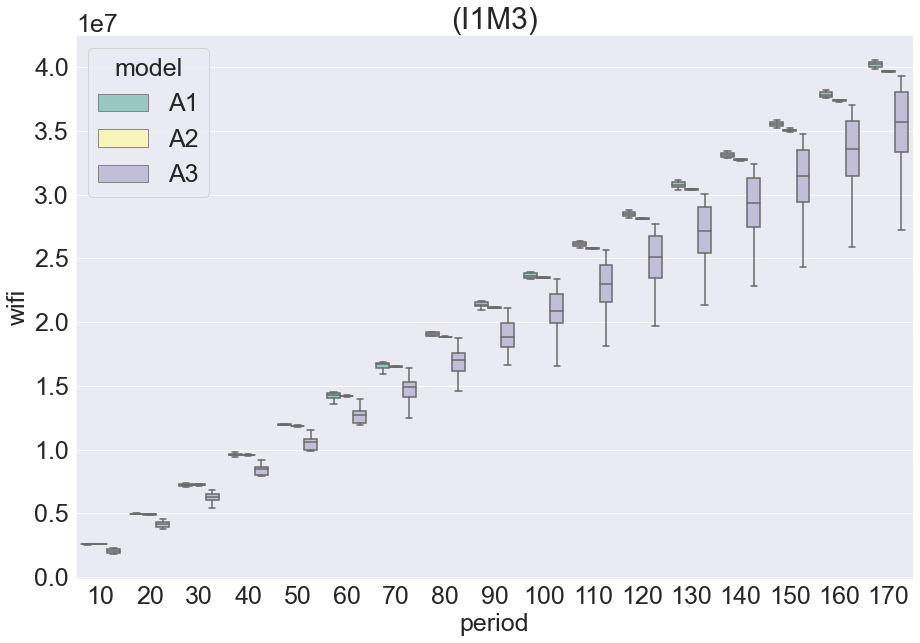

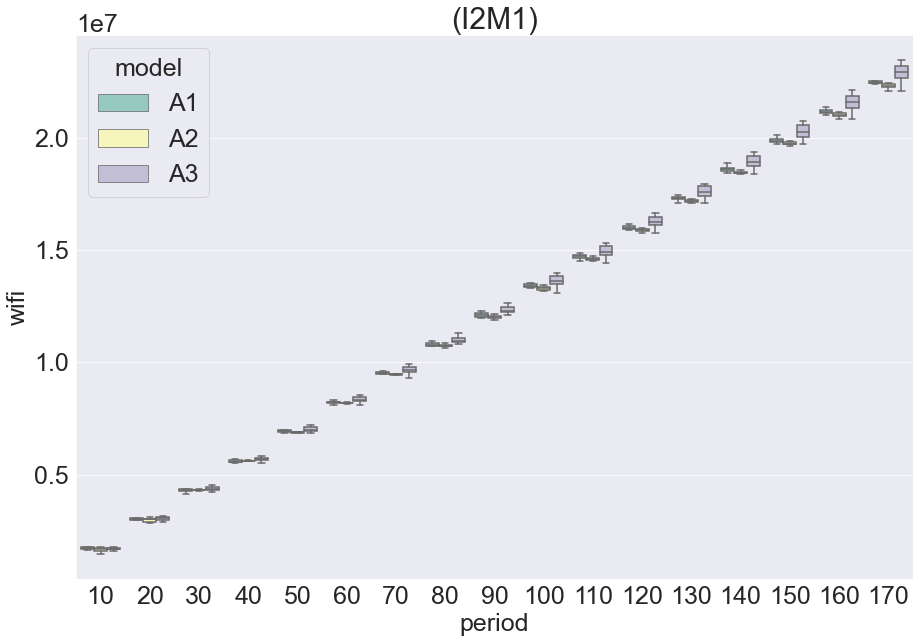

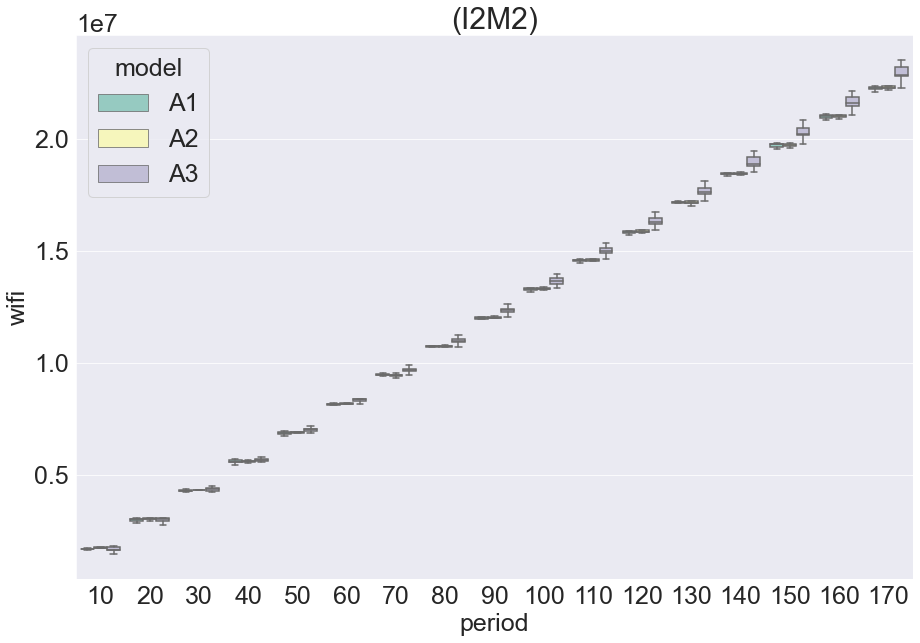

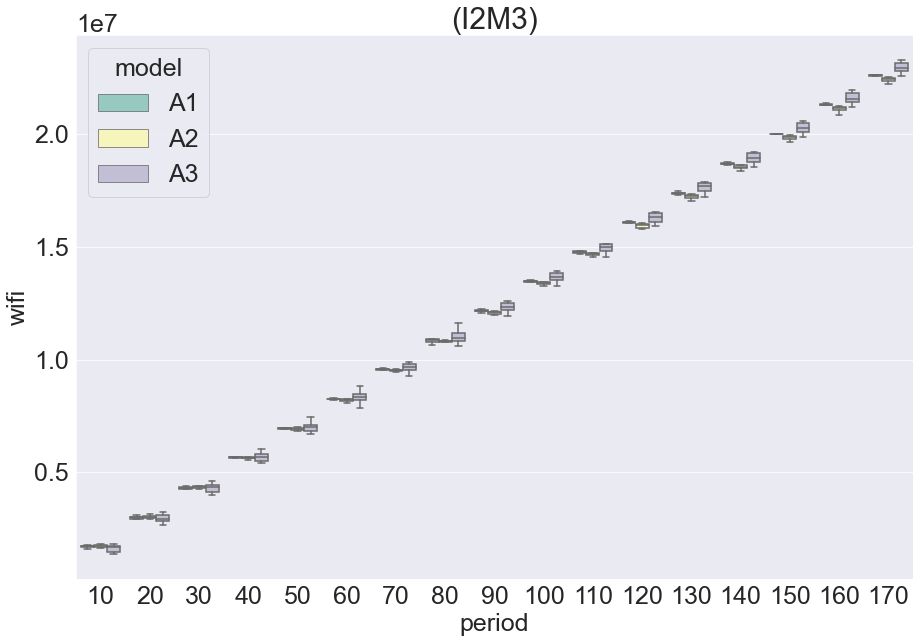

In [183]:
plot_stats(experiments_df, 'wifi')
# 3 x 6
#

A1
A2
A3
A1
A2
A3
A1
A2
A3


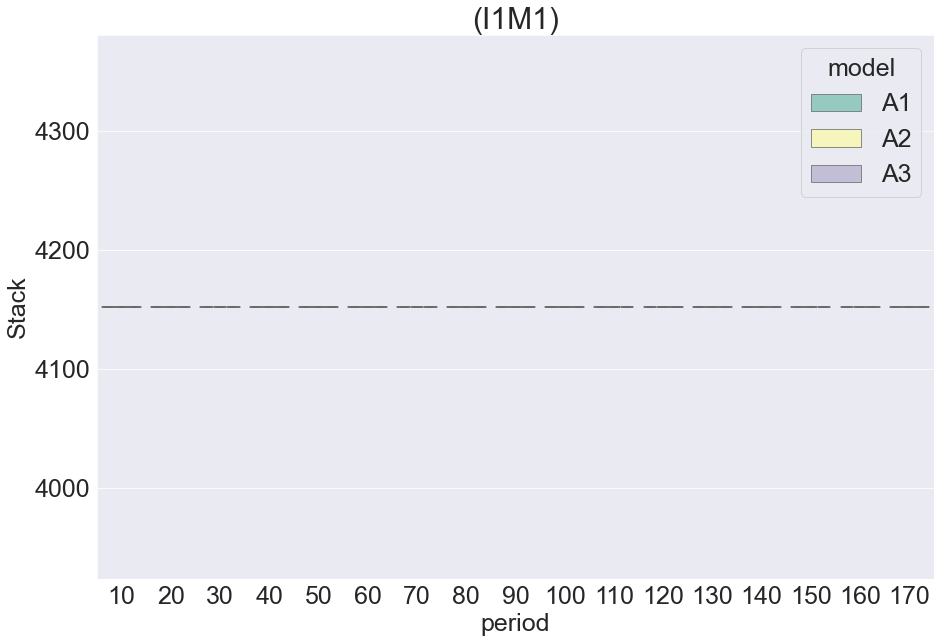

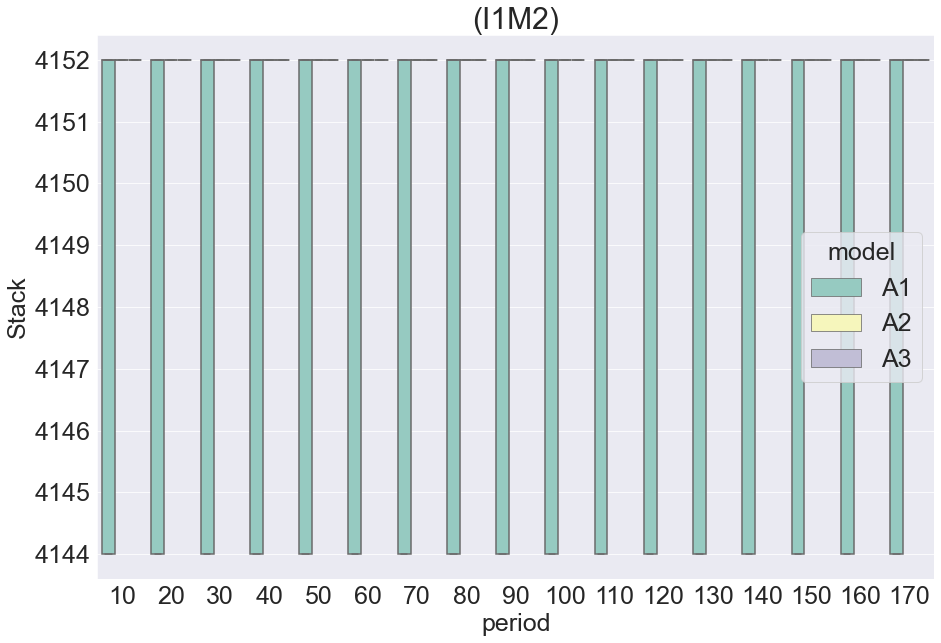

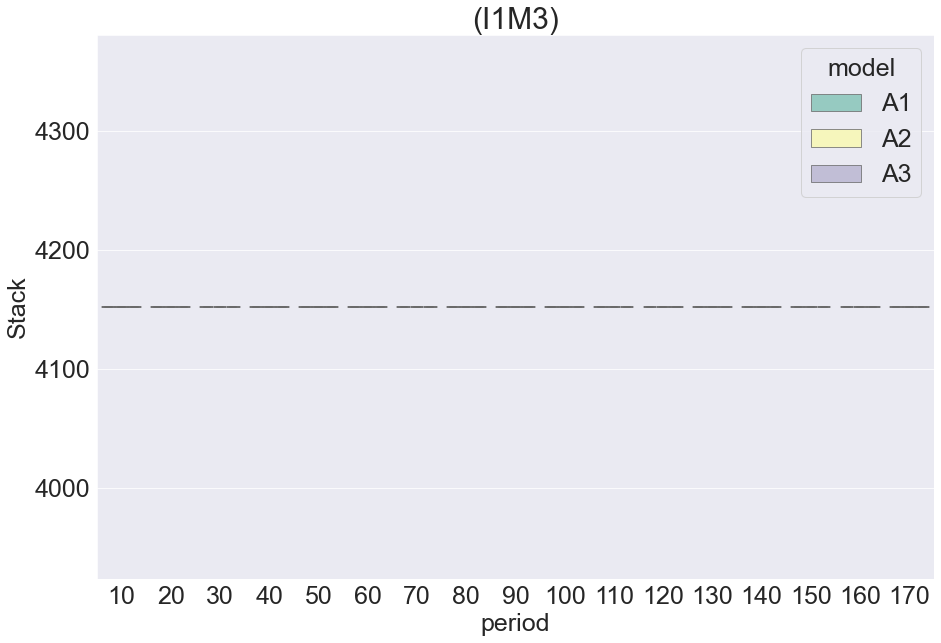

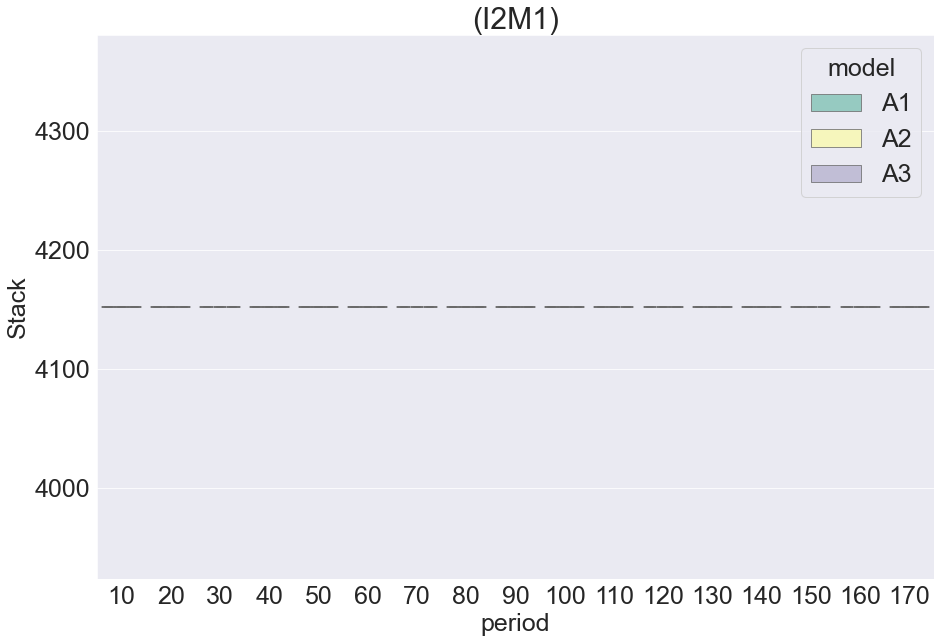

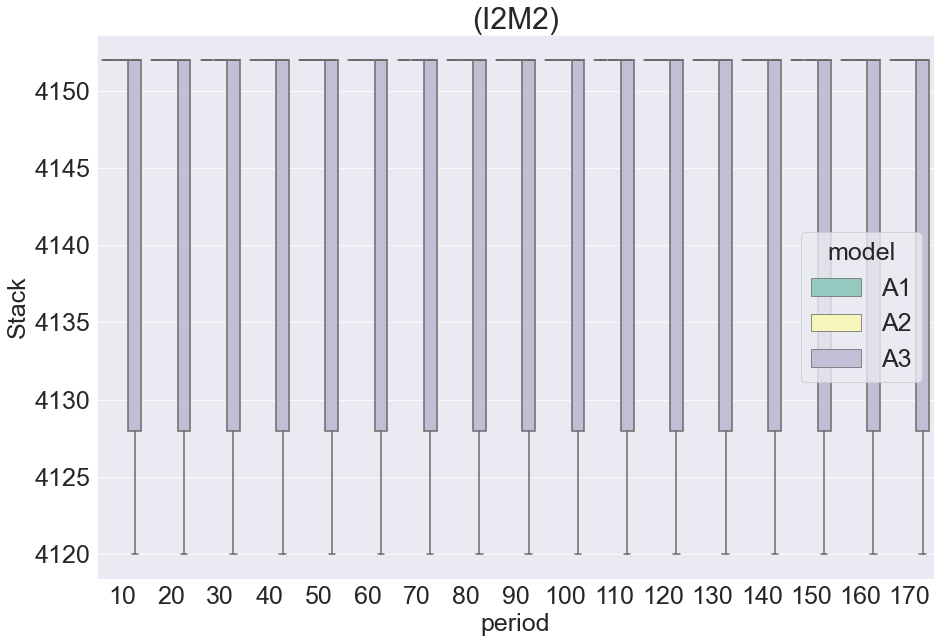

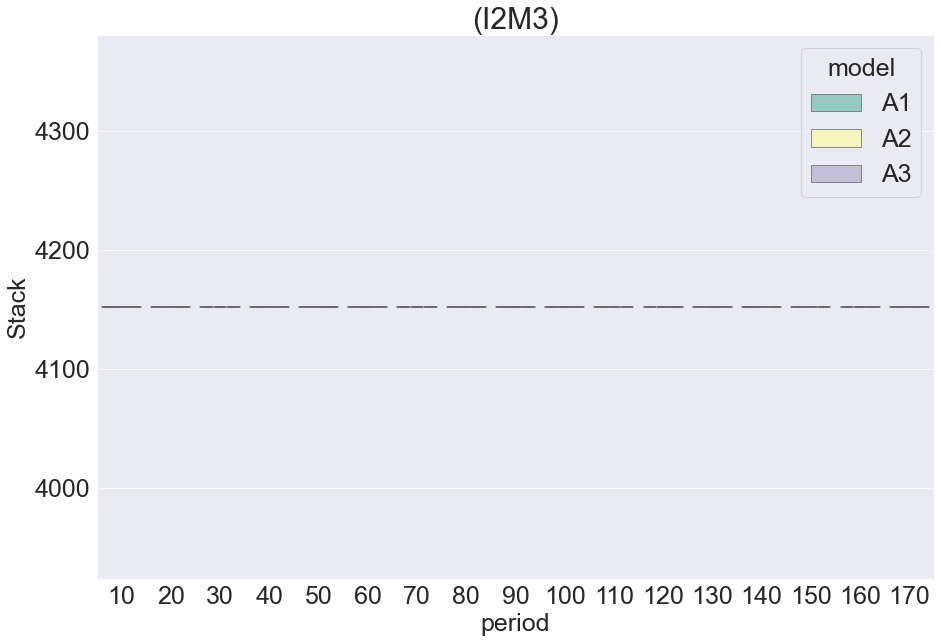

In [184]:
plot_stats(experiments_df, 'Stack')

A1
A2
A3
A1
A2
A3
A1
A2
A3


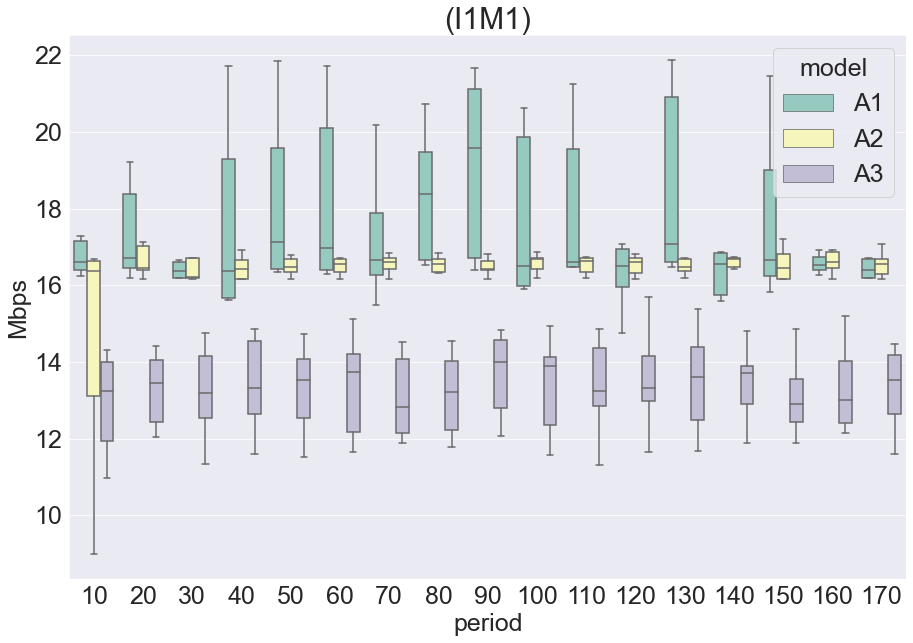

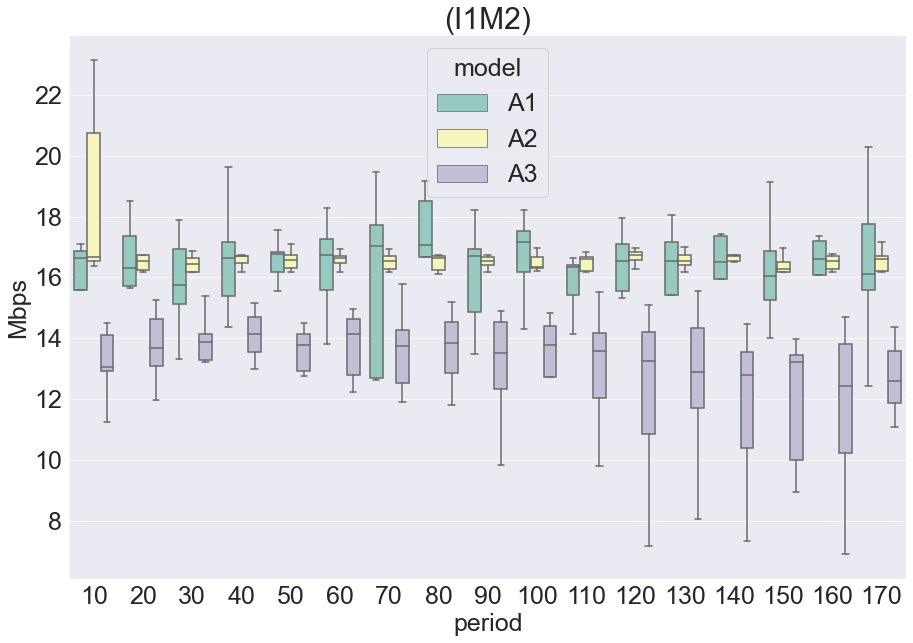

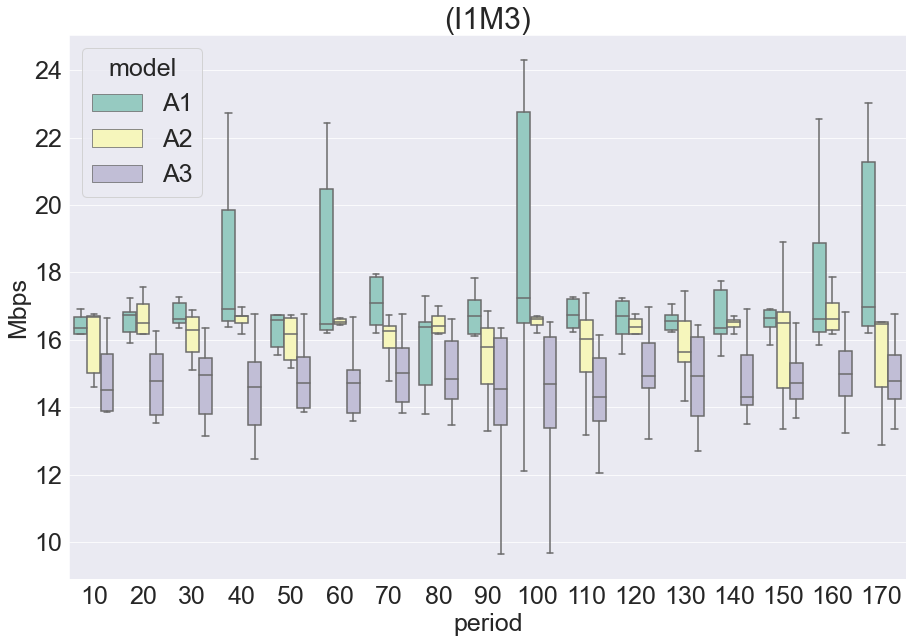

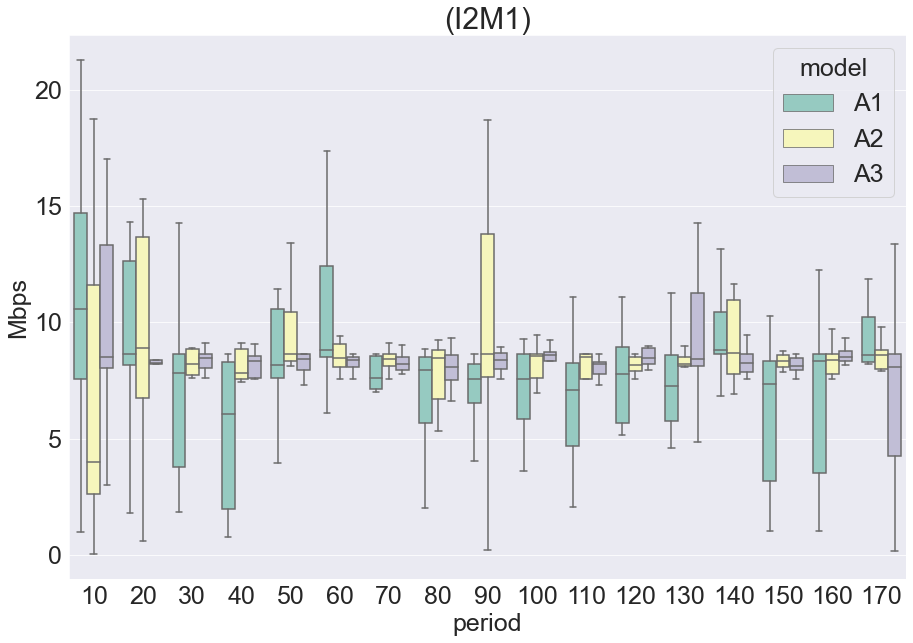

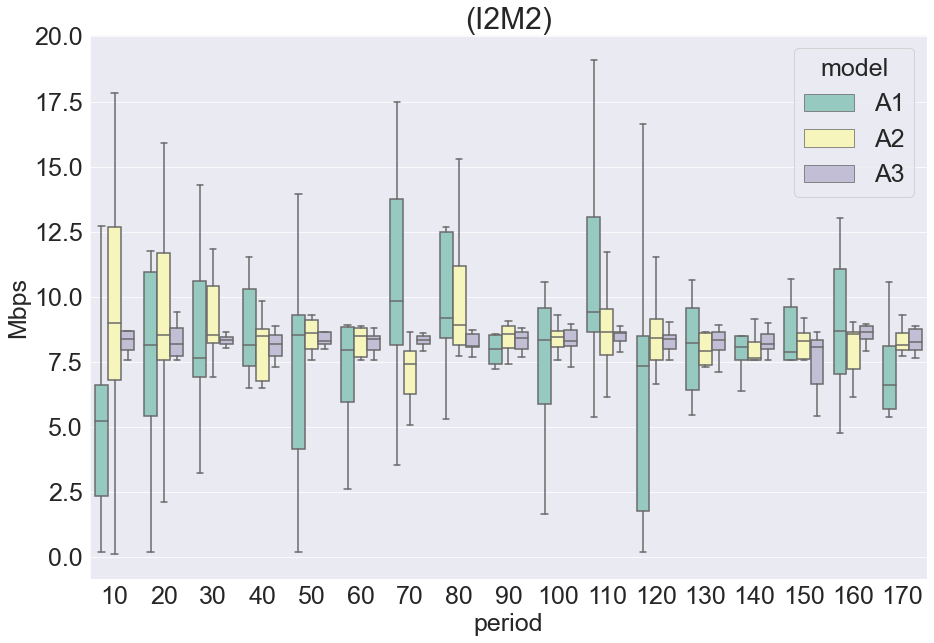

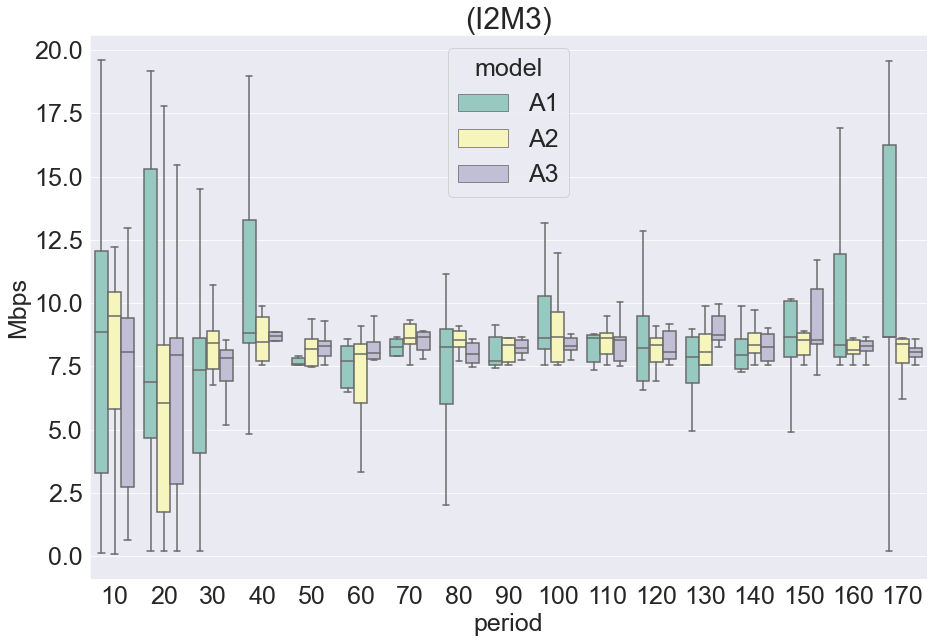

In [185]:
plot_stats(experiments_df, 'Mbps')